# Анализ данных аренды самокатов GoFast

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
**Цель:** Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
    
**Описание данных:**

Предоставлены три таблицы: 
1. Пользователи

- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

2. Поездки

- `user_id`	- уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

3. Подписки 

- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

**План работы:**

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчет выручки
6. Проверка гипотез
7. Решение задач с помощью распределений

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import math
from scipy import stats as st
from scipy.stats import binom, norm

### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('C:/FATHER/datasets/users_go.csv')

rides = pd.read_csv('C:/FATHER/datasets/rides_go.csv')

subscriptions = pd.read_csv('C:/FATHER/datasets/subscriptions_go.csv')

Посмотрим информацию о пользователях.

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Посмотрим информацио о поездках

In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Посмотрим информацию о подписках

In [7]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:**

Нам предоставлены три таблицы. В таблице `users` 1565 строчка, в таблице `rides` - 18068, в `subscriptions` - 2. Все столбцы представлены в нужном типе данных, кроме столбца `date` в таблице `rides`.

### Шаг 2. Предобработка данных

В таблице `rides` приведем тип данных столбца `date` к типу даты Pandas.

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

 Создадим новый столбец с номером месяца на основе столбца date.

In [10]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

Проверим нет ли в данных пропущенных значений.

In [11]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [13]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Проверим нет ли в данных дубликатов.

In [14]:
users.duplicated().sum()

31

Удалим дубликаты в таблице `users`.

In [15]:
users = users.drop_duplicates()

In [16]:
rides.duplicated().sum()

0

В таблице `subscriptions` всего две строчки, которые не повторяются.

**Вывод:**

Мы проверили есть ли в данных дубликаты и удалили имеющиеся. Пропусков в данных нет. Можно приступать к исследовательскому анализу.

### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.

#### Частота встречаемости городов.

In [17]:
city = users.pivot_table(index='city',values='name',aggfunc='count').sort_values(by='name',ascending=False)
city.columns=['count']
city

,count
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


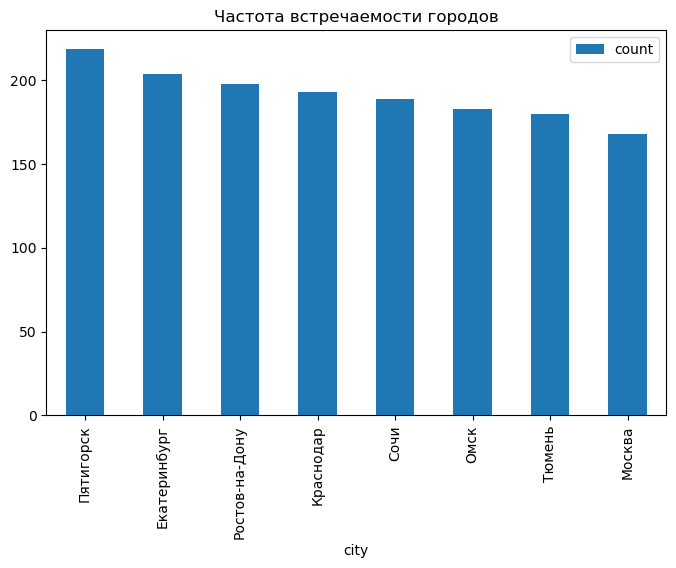

In [18]:
(city.plot(kind='bar', figsize=(8,5)),
    plt.title('Частота встречаемости городов'));
     

#### Соотношение пользователей с подпиской и без подписки.

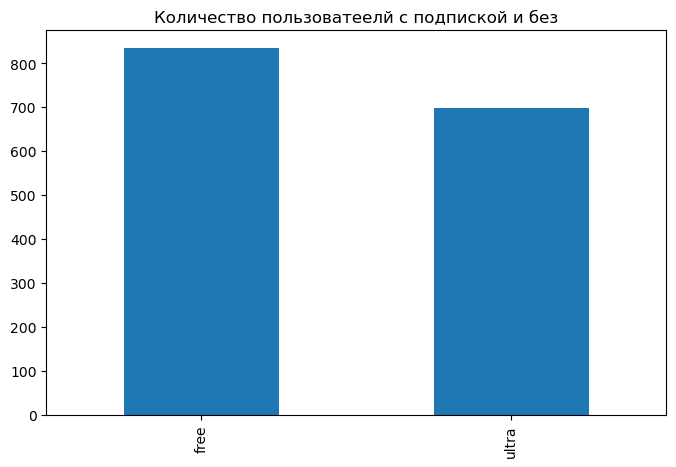

In [19]:
subscription = users['subscription_type'].value_counts()

(subscription.plot(kind='bar', figsize=(8,5)),
    plt.title('Количество пользоватеелй с подпиской и без'));

In [20]:
print('Пользователей без подписки в', round(subscription[0]/subscription[1],2), 'раза больше чем с подпиской.')

Пользователей без подписки в 1.19 раза больше чем с подпиской.


#### Возраст пользователей.

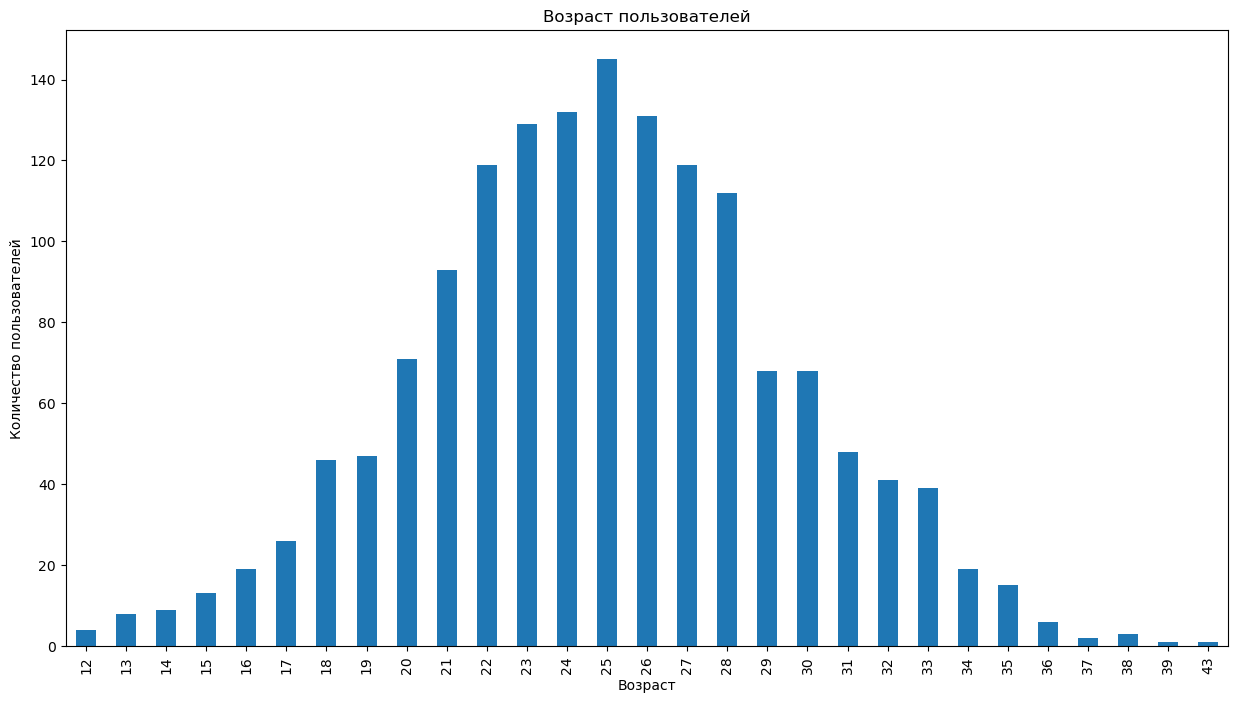

In [21]:
age = users['age'].value_counts().sort_index()

(age.plot(kind='bar', figsize=(15,8)),
    plt.title('Возраст пользователей'),
    plt.xlabel('Возраст'),
    plt.ylabel('Количество пользователей'));

#### Расстояния, которые пользователи проезжают за одну поездку.

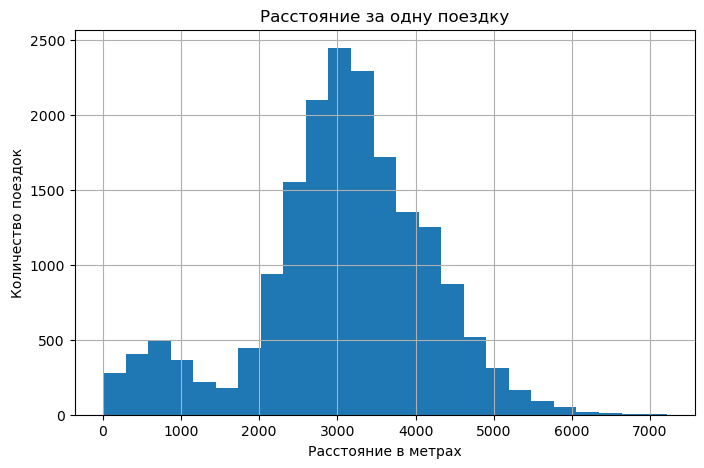

In [22]:
rides['distance'].hist(bins=25, figsize=(8,5))
plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок');

#### Продолжительность поездок.

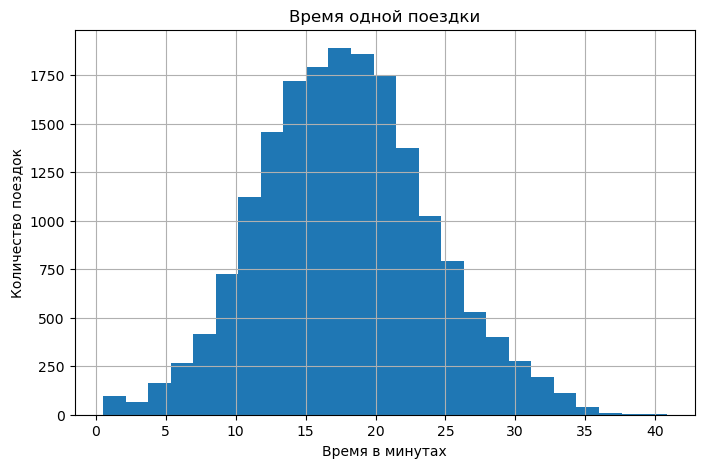

In [23]:
rides['duration'].hist(bins=25, figsize=(8,5))
plt.title('Время одной поездки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок');

**Вывод:**

1. Больше всего в данных пользователей из Пятигорска, меньше всего из Москвы. Количество пользователей в каждом городе от 168 до 219 человек.
2. Пользователей без подписки больше, но всего в 1,19 раза.
3. Возраст пользоватлей нормально распределен. Больше все пользвателей в возрасте 25 лет и намного меньше в возрасте до 15 и после 35.
4. Чаще всего пользователи за одну поездку проезжают около трех километров.
5. Чаще всего поездки длятся от 15 до 20 минут.


### Шаг 4. Объединение данных

Объединим данные из трех таблиц в один датафрейм.

In [24]:
data = users.merge(rides, on='user_id')
data = data.merge(subscriptions, on='subscription_type')

Проверим нужного ли размера получился датафрейм и не осталось ли пропусков после соединения таблиц.

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Количество строк в этом датафрейме должно быть равно количеству строк из датафрейма `rides`, то есть 18068. По выводу функции `info()` мы видим, что так и есть. Также заметим, что ни в одном столбце нет пропусков.

Разделим созданный датафрейм на два новых с данными о пользователях с подпиской и без.

In [26]:
data_ultra = data[data['subscription_type'] == 'ultra'].reset_index(drop=True)
data_ultra.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [27]:
data_free = data.query('subscription_type == "free"').reset_index(drop=True)
data_free.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

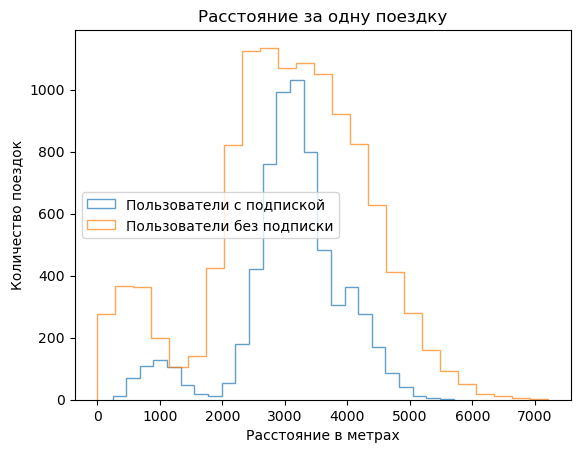

In [28]:
ax = data_ultra['distance'].plot(kind='hist',bins=25, 
                                 histtype='step',alpha=0.7, 
                                 label='Пользователи с подпиской', 
                                 legend=True)


data_free['distance'].plot(kind='hist',bins=25,
                           alpha=0.7, histtype='step',
                           label='Пользователи без подписки',
                           ax=ax, legend=True)



plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

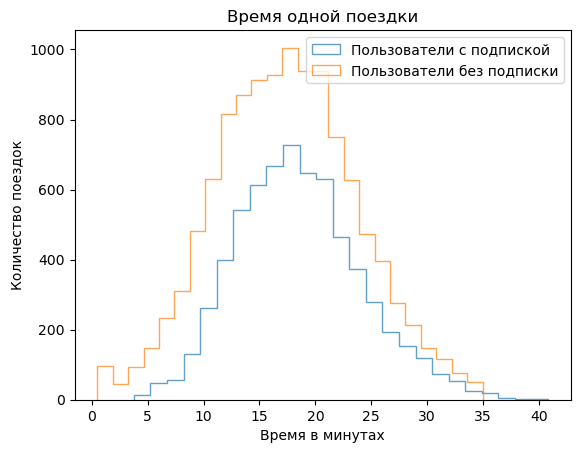

In [29]:
ax = data_ultra['duration'].plot(kind='hist',bins=25, 
                                 histtype='step',alpha=0.7, 
                                 label='Пользователи с подпиской',
                                 legend=True)


data_free['duration'].plot(kind='hist',bins=25,
                           alpha=0.7, histtype='step',
                           label='Пользователи без подписки',
                           ax=ax, legend=True)



plt.title('Время одной поездки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')
plt.show()

**Вывод:**

Мы создали два датафрейма, в которых хранятся данные о пользлвателях с подпиской и без нее.

Расстояние, которые пользователи проезжают за одну поездку, у обоих категорий почти одинаково. Чаще всего оно составляет 3 километра. Однако пользователи без подписки чаще ездят на расстояния меньше 2 км.

Время также почти совпадет. Чаще всего длительность поезки от 15 до 20 минут. Но можно заметить, что пользователи с подпиской чаще совершают поездки дольше 30 минут. 

Неточность в сравнении графиков может быть обусловлена тем, что данных о пользователях с подпиской меньше чем данных о пользлвателях без нее.

### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках, где посчитаем общее расстояние и время по каждому месяцу для каждого пользователя.

In [30]:
# Округлим длительность перед расчетами
data['duration'] = round(data['duration'])

In [31]:
s_type = lambda x: x.value_counts().index[0]

In [32]:
data_group = data.groupby(['user_id', 'month'], as_index=False).agg({'distance':['sum', 'count'],
                                                                     'duration':['sum'],
                                                                     'subscription_type':[s_type]})

data_group.columns = ['user_id','month','total_distance','rides','total_duration','subscription_type']
data_group.head(10)

,user_id,month,total_distance,rides,total_duration,subscription_type
0,1,1,7027.511294,2,42.0,ultra
1,1,4,754.159807,1,6.0,ultra
2,1,8,6723.470560,2,45.0,ultra
3,1,10,5809.911100,2,32.0,ultra
4,1,11,7003.499363,3,53.0,ultra
5,1,12,6751.629942,2,28.0,ultra
6,2,3,10187.723006,3,61.0,ultra
7,2,4,6164.381824,2,39.0,ultra
8,2,6,3255.338202,1,14.0,ultra
9,2,7,6780.722964,2,46.0,ultra


В этот датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [33]:
def proceeds (x):
    y = x[3] * subscriptions.loc[subscriptions['subscription_type']==x[5],'start_ride_price']\
                                + math.ceil(x[4])*subscriptions.loc[subscriptions['subscription_type']==x[5],'minute_price']\
                                + subscriptions.loc[subscriptions['subscription_type']==x[5],'subscription_fee']
    return y.values[0]


data_group['proceeds'] = data_group.apply( proceeds, axis=1)
data_group.tail()


,user_id,month,total_distance,rides,total_duration,subscription_type,proceeds
11326,1534,6,3409.468534,2,24.0,free,292
11327,1534,8,7622.453034,2,47.0,free,476
11328,1534,9,4928.173852,1,23.0,free,234
11329,1534,11,13350.015305,4,76.0,free,808
11330,1534,12,2371.711192,1,16.0,free,178


### Шаг 6. Проверка гипотез

Проверим несколько гипотез.

#### Первая гипотеза
Нужно понять тратят ли пользователи с подпиской больше времени на поездки.

**Нулевая гипотеза**: Пользователи с подпиской тратят столько же времени на поездки как и пользователи без подписки.

**Альтернативная гипотеза**:  Пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки.

In [34]:
alpha = 0.05

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var=False, alternative='greater')

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


#### Вторая гипотеза

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим не превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, 3130 метров.

**Нулевая гипотеза**: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м.

**Альтернативная гипотеза**: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 м.

In [35]:
ave_dist = 3130

alpha = 0.05 

results = st.ttest_1samp(data_ultra['distance'], ave_dist, alternative='greater')

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-value: 0.9195368847849785
Не отвергаем нулевую гипотезу


#### Третья гипотеза
**Нулевая гипотеза**: Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки. 

**Альтернативная гипотеза**: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 


In [36]:
pr_ultra = data_group.loc[data_group['subscription_type'] == 'ultra','proceeds']
pr_free = data_group.loc[data_group['subscription_type'] == 'free', 'proceeds']

alpha = 0.05

results = st.ttest_ind(pr_ultra, pr_free, equal_var=False, alternative='greater')

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.6046721201208006e-47
Отвергаем нулевую гипотезу


#### Четвертая гипотеза

Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

**Нулевая гипотеза**: Количество обращений в техподдержку не изменилось.

**Альтернативная гипотеза**: Количество обращений в техподдержку стало меньше.

Это левосторонняя гипотеза. Чтобы проверить ее, нужно будет обратиться к методу `scipy.stats.ttest_rel()`, так как данные зависимы друг от друга.

**Вывод**:
1. Есть основания полагать, что пользователи с подпиской тратят значительно больше времени на поездки чем пользователи без подписки.
2. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, чаще всего равно или меньше 3130 м.
3. Скорее всего помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4. Чтобы проверить четвертую гипотезу нужно воспользаваться методом `scipy.stats.ttest_rel()`.

### Шаг 7. Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей.

Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

In [37]:
p = 0.1

for n in range(1000, 2000):
    result = 0
    for k in range (0,100):
        
        result += binom.pmf(k, n, p)
    
    if 4.9 < result*100 <= 5 :
        
        print('Минимально нужно разослать',n,'промокодов.')
        print('Вероятность не выполнить план примерно',round(result*100),'%.')
        break

Минимально нужно разослать 1161 промокодов.
Вероятность не выполнить план примерно 5 %.


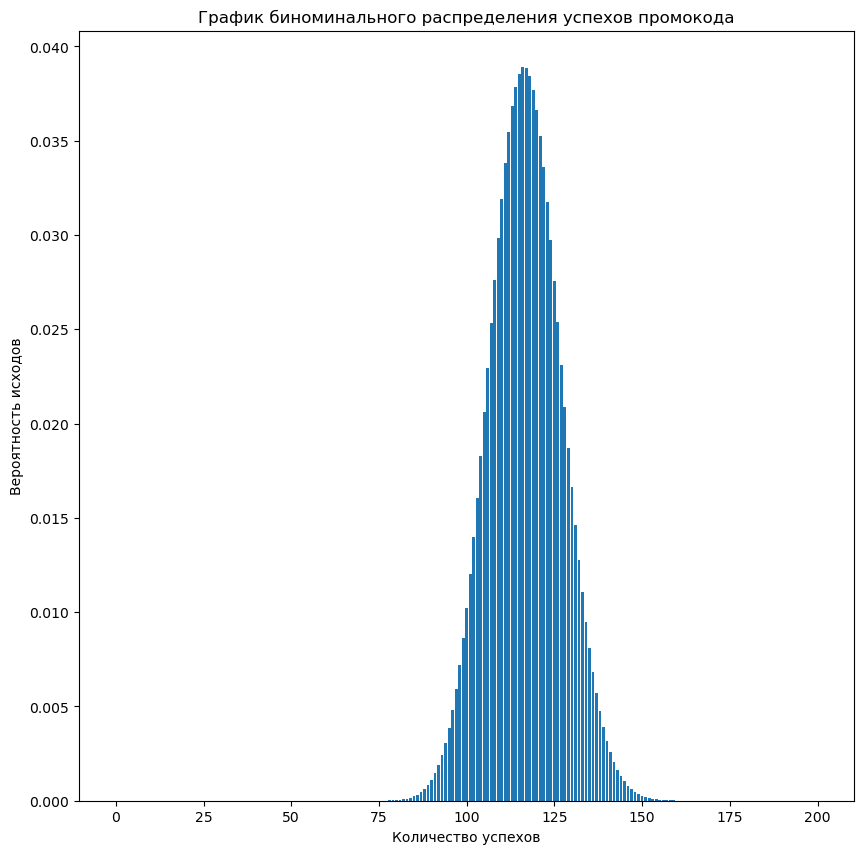

In [38]:
n = 1168 
p = 0.1 

distr = []

for k in range(0, 201):
    choose = math.factorial(n) / (math.factorial(k) * math.factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)
    
plt.figure(figsize=(10, 10))    
plt.bar(range(0, 201), distr)
plt.xlabel('Количество успехов')
plt.ylabel('Вероятность исходов')
plt.title('График биноминального распределения успехов промокода')
plt.show()

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. 

С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

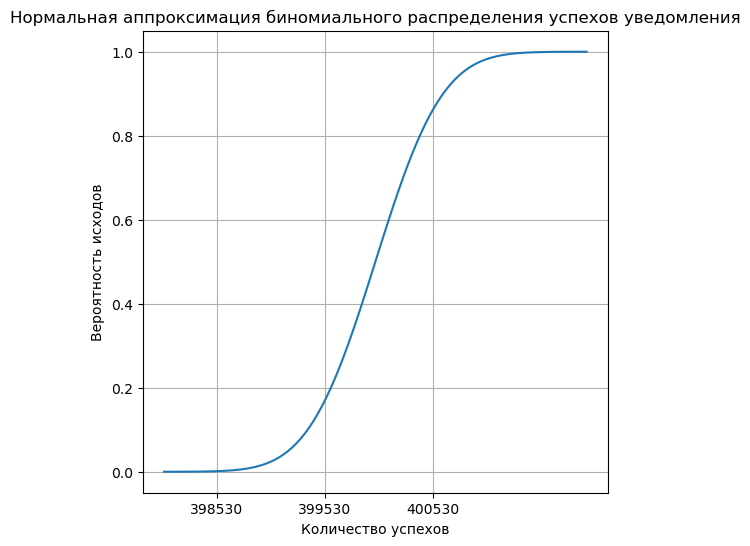

In [39]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 

n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию
left = int(n * p - 4 * math.sqrt(n * p * (1 - p)))
right = int(n * p + 4 * math.sqrt(n * p * (1 - p)))

mu = n * p
sigma = math.sqrt(n * p * (1 - p))
 
x = linspace(left, right, 100)

plt.figure(figsize=(6, 6))

plt.plot(x, st.norm(mu, sigma).cdf(x))

x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1000))
plt.xticks(x_ticks)

plt.title('Нормальная аппроксимация биномиального распределения успехов уведомления')
plt.xlabel('Количество успехов')
plt.ylabel('Вероятность исходов')
plt.grid (True)
plt.show()


In [40]:
n = 1000000
p = 0.4

mu = n * p
sigma = math.sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) 

result = distr.cdf(399500)
print(result)

0.15371708296369768


**Вывод**:
1. Чтобы вероятность не выполнить план была примерно 5 %, нужно разослать миниму 1161 промокод. На графике видно что при таком количество промокодов, вероятность, что 100 человек не продлят подписку, достаточно мала.
2. По графику можно предположить, что уведомление откроют не более 399,5 тыс. пользователей с вероятностью меньше 20%. Сделав вычисления, мы узначи, что точна вероятность составляет 15,4%.

### Общий вывод

Мы проанализировали данные и проверили некоторые гипотезы, которые могут помочь бизнесу вырасти.

Мы выполнили все пункты плана:
1. Загрузили данные


2. Провели предобработку данных
    - Изменили тип данных, где это было необходимо
    - Добавили новый столбец с номером месяца
    - Проверили наличие пропущенных значений, дубликатов в датафреймах и обработали их.
    
    
3. Провели исследовательский анализ данных и сделали следующие выводы:
    - Больше всего в данных пользователей из Пятигорска, меньше всего из Москвы. Количество пользователей в каждом городе больше 150 и меньше 250 человек.
    - Пользователей без подписки больше, но всего в 1,19 раза.
    - Возраст пользоватлей нормально распределен. Больше все пользвателей в возрасте 25 лет и намного меньше в возрасте до 15 и после 35.
    - Чаще всего пользователи за одну поездку проезжают около трех километров.
    - Чаще всего поездки длятся от 15 до 20 минут.
    
    
4. Объединили данные, а также сравнили информацию о расстоянии и времени поездок для пользователей с подпиской и без нее. Сделали выводы:
    - Чаще всего расстояние, которые пользователи проезжают за одну поездку, составляет 3 километра. Однако пользователи без подписки чаще ездят на расстояния меньше 2 км.
    - Чаще всего длительность поезки от 15 до 20 минут. Но можно заметить, что пользователи с подпиской чаще совершают поездки дольше 30 минут.
    
    
5. Посчитали выручку по месяцам, которую приносит каждый пользователь.


6. Проверили гипотезы и сделали выводы:
    - Есть основания полагать, что пользователи с подпиской тратят значительно больше времени на поездки чем пользователи без подписки.
    - Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, чаще всего равно или меньше 3130 м.
    - Скорее всего помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
    
    
7. Решили задачи с помощью распределений